In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
beer_recipe = pd.read_csv('D:/beer-recipes/recipeData.csv', index_col='BeerID', encoding='latin1')
beer_recipe.head()

,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,Color,...,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
BeerID,,,,,,,,,,,,,,,,,,,,,
1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,4.83,...,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.0
2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,15.64,...,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.0
3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,8.98,...,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN
4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,8.50,...,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN
5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,4.57,...,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l,18325.0


Vamos analisar algumas informações contidas nesse dataset e compreender as informações

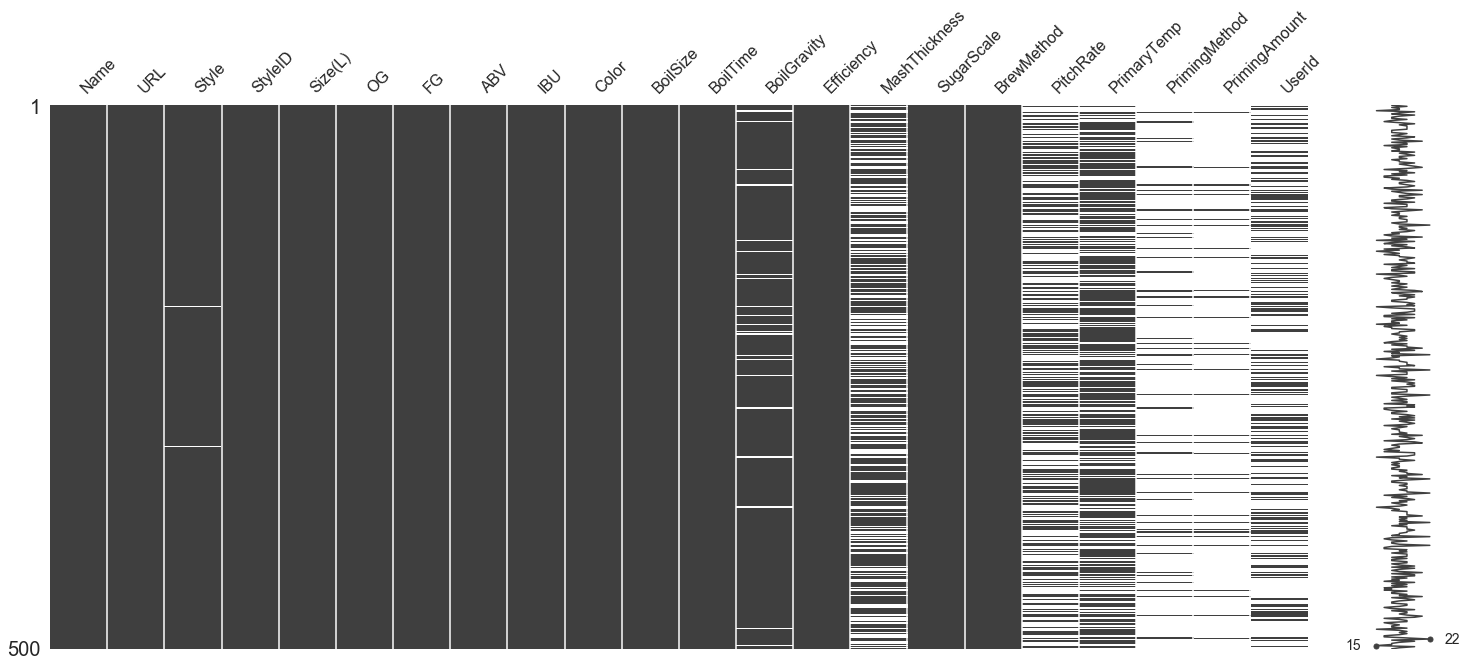

In [3]:
%matplotlib inline
msno.matrix(beer_recipe.sample(500))

Foi possível identificar que os valores PrimingMethod e PrimingAmount, nem sempre estão presentes. Mas o que seria o priming?
Priming é um processo na produção da cerveja, no final da produção, após a fermentação, antes de realizar o envaze em garrafa ou outro recipiente, alguns cervejeiros optam por fazer o priming, que consiste em adicionar uma calda de açúcar proprocionalmente a quantidade que você possui de litros e qual será o volume aproximado de CO2 na cerveja, o priming é responsável por refermentar a cerveja, gerando o CO2 para a cerveja e assim carbonatando ela. Outra alternativa ao priming muito utilizada é a carbonatação forçada, onde o cervejeiro com os equipamentos necessários faz a inserção forçada de CO2 através de um cilindro.

# Priming
    Agora que entendemos o que priming se refere, vamos visualizar qual é a ausência dessa informação nas receitas presentes desse dataset

In [4]:
null_priming = beer_recipe['PrimingMethod'].isnull()
print('Priming Method is null on {} rows out of {}, so {} % of the time'.format(null_priming.sum(), len(beer_recipe), round((null_priming.sum()/len(beer_recipe))*100,2)))

Priming Method is null on 67095 rows out of 73861, so 90.84 % of the time


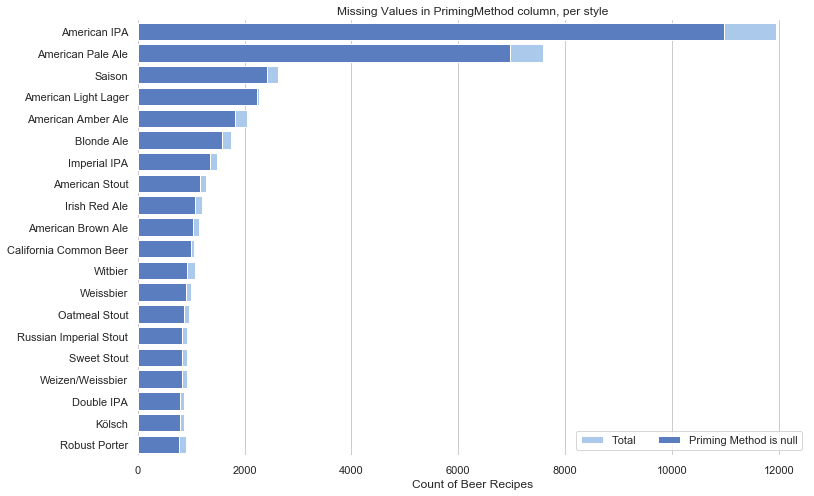

In [5]:
style_cnt = beer_recipe.loc[:,['Style','PrimingMethod']]
style_cnt['NullPriming'] = style_cnt['PrimingMethod'].isnull()
style_cnt['Count'] = 1
style_cnt_grp = style_cnt.loc[:,['Style','Count','NullPriming']].groupby('Style').sum()

style_cnt_grp = style_cnt_grp.sort_values('NullPriming', ascending=False)
style_cnt_grp.reset_index(inplace=True)

def stacked_bar_plot(df, x_total, x_sub_total, sub_total_label, y):
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the total
    sns.set_color_codes("pastel")
    sns.barplot(x=x_total, y=y, data=df, label="Total", color="b")

    # Plot
    sns.set_color_codes("muted")
    sns.barplot(x=x_sub_total, y=y, data=df, label=sub_total_label, color="b")
    
    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="lower right", frameon=True)
    sns.despine(left=True, bottom=True)
    
    return f, ax
    
f, ax = stacked_bar_plot(style_cnt_grp[:20], 'Count', 'NullPriming', 'Priming Method is null', 'Style')
ax.set(title='Missing Values in PrimingMethod column, per style', ylabel='', xlabel='Count of Beer Recipes')
sns.despine(left=True, bottom=True)

Features Categóricas

In [6]:
print( list(beer_recipe.select_dtypes(include=object).columns))

['Name', 'URL', 'Style', 'SugarScale', 'BrewMethod', 'PrimingMethod', 'PrimingAmount']


In [7]:
print(beer_recipe.PrimingAmount.unique())

['4.5 oz' nan '6-7 g sukker/l' ...
 '4.79oz for 6gal  4.5oz for 5.75  4.32 for 5.5gal  4.12oz for 5.25gal  3.93oz for 5 gal.'
 '13.5' '7 gram / liter']


SugarScale has 0 null values


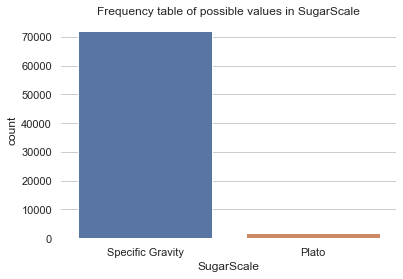

In [8]:
ax = sns.countplot(x='SugarScale', data=beer_recipe)
ax.set(title='Frequency table of possible values in SugarScale')
sns.despine(left=True, bottom=True)

print('SugarScale has {} null values'.format(beer_recipe.SugarScale.isnull().sum()))

# Métodos de fabricação
Existem diversos métodos de fabricação, os mais comuns e utilizados são All Grain, extract, BIAB, Partial Mash

* Onde o método All Grain, é o mais utilizado, conforme é possível visualizar na recorrencia do dataset. O método all grain consiste na utilização 100% de grãos na mostura.

* Método extract, é uma brassagem à partir de extrato de malte, onde você normalmente, você "pula" o processo de brassagem, cozimento dos grãos, e vai direto para a fervura.

* BIAB é o mesmo que o All Grain, onde difere o recipiente que é cozido os grãos, onde normalmente as panelas são separadas em panela de mostura, fervura, o biab você faz tudo em uma única panela, com auxílio de um grain bag, no final da mostura você retira os grãos da panela e inicia a fervura.

* Partial Mash consiste em fazer uma brassagem com uma parte de grãos e complementar com o extrato.

BrewMethod has 0 null values


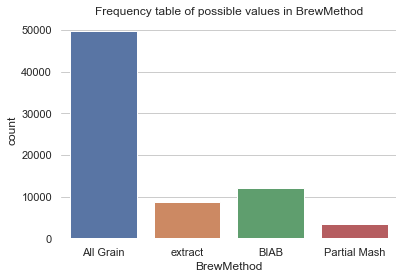

In [9]:
ax = sns.countplot(x='BrewMethod', data=beer_recipe)
ax.set(title='Frequency table of possible values in BrewMethod')
sns.despine(left=True, bottom=True)

print('BrewMethod has {} null values'.format(beer_recipe.BrewMethod.isnull().sum()))

In [10]:
print('PrimingMethod has {} unique values'.format(beer_recipe.PrimingMethod.nunique()))
print(beer_recipe.PrimingMethod.unique()[:20])

PrimingMethod has 874 unique values
['corn sugar' nan 'Sukkerlake' 'Corn Sugar' 'Priming Sugar'
 'Keg - Force Carb.' 'Force Carb' 'Force carb' 'Forced Carbonation'
 'DME boiled in 2 cups water' 'force carb' 'Dextrose' 'Sukker' 'Sugar'
 'FORCED CARB' 'Inverted sugar' 'honey' 'CO2' 'Add in last 5 of boil'
 'priming sugar']


# Features Numéricas

In [11]:
print( list( beer_recipe.select_dtypes(exclude=object)))

['StyleID', 'Size(L)', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'BoilGravity', 'Efficiency', 'MashThickness', 'PitchRate', 'PrimaryTemp', 'UserId']


In [12]:
def get_sg_from_plato(plato):
    sg = 1 + (plato / (258.6 - ( (plato/258.2) *227.1) ) )
    return sg

beer_recipe['OG_sg'] = beer_recipe.apply(lambda row: get_sg_from_plato(row['OG']) if row['SugarScale'] == 'Plato' else row['OG'], axis=1)
beer_recipe['FG_sg'] = beer_recipe.apply(lambda row: get_sg_from_plato(row['FG']) if row['SugarScale'] == 'Plato' else row['FG'], axis=1)
beer_recipe['BoilGravity_sg'] = beer_recipe.apply(lambda row: get_sg_from_plato(row['BoilGravity']) if row['SugarScale'] == 'Plato' else row['BoilGravity'], axis=1)

In [13]:
num_feats_list = ['Size(L)', 'OG_sg', 'FG_sg', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'BoilGravity_sg', 'Efficiency', 'MashThickness', 'PitchRate', 'PrimaryTemp']
beer_recipe.loc[:, num_feats_list].describe().T

,count,mean,std,min,25%,50%,75%,max
Size(L),73861.0,43.929775,180.373492,1.000,18.930,20.820,23.660,9200.000
OG_sg,73861.0,1.060846,0.057580,1.000,1.050,1.057,1.067,15.897
FG_sg,73861.0,1.013976,0.012187,0.991,1.011,1.013,1.016,3.974
ABV,73861.0,6.136865,1.883510,0.000,5.080,5.790,6.830,54.720
IBU,73861.0,44.276186,42.945508,0.000,23.370,35.770,56.380,3409.300
Color,73861.0,13.404989,11.944511,0.000,5.170,8.440,16.790,186.000
BoilSize,73861.0,49.724919,193.246427,1.000,20.820,27.440,30.000,9700.000
BoilTime,73861.0,65.074870,15.024228,0.000,60.000,60.000,60.000,240.000
BoilGravity_sg,70871.0,1.053498,0.027301,1.000,1.040,1.047,1.058,1.500
Efficiency,73861.0,66.354881,14.091686,0.000,65.000,70.000,75.000,100.000


In [14]:
vlow_scale_feats = ['OG_sg', 'FG_sg', 'BoilGravity_sg', 'PitchRate']
low_scale_feats = ['ABV', 'MashThickness']
mid_scale_feats = ['Color', 'BoilTime', 'Efficiency', 'PrimaryTemp']
high_scale_feats = ['IBU', 'Size(L)',  'BoilSize']

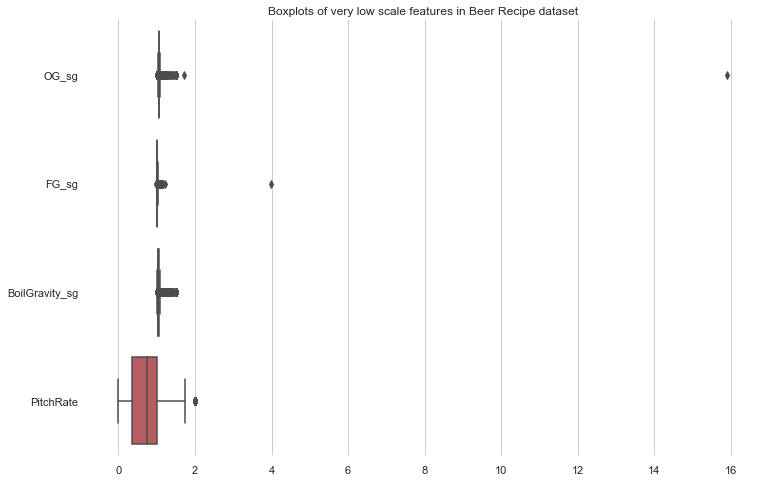

In [15]:
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(data=beer_recipe.loc[:, vlow_scale_feats], orient='h')
ax.set(title='Boxplots of very low scale features in Beer Recipe dataset')
sns.despine(left=True, bottom=True)

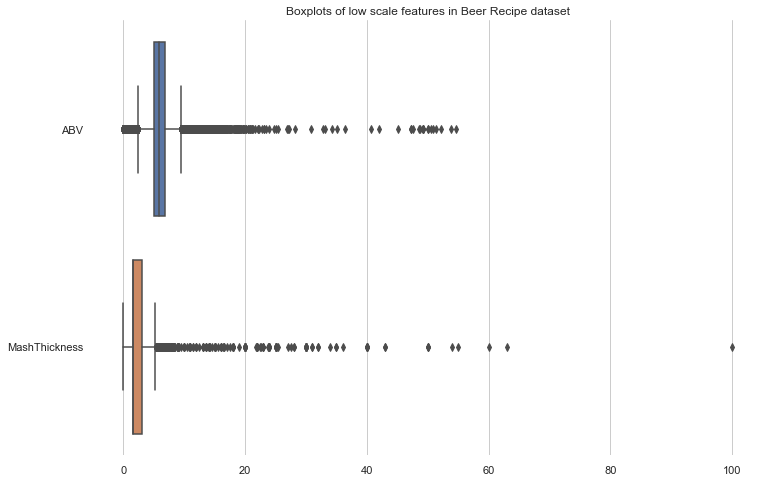

In [16]:
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(data=beer_recipe.loc[:, low_scale_feats], orient='h')
ax.set(title='Boxplots of low scale features in Beer Recipe dataset')
sns.despine(left=True, bottom=True)

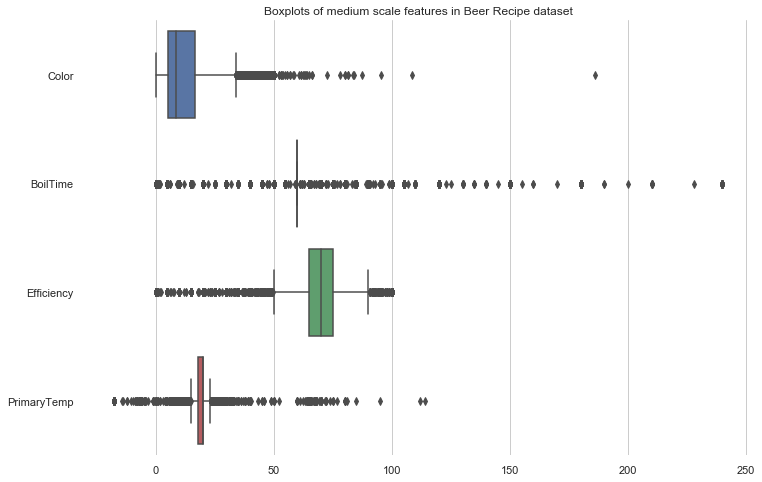

In [17]:
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(data=beer_recipe.loc[:, mid_scale_feats], orient='h')
ax.set(title='Boxplots of medium scale features in Beer Recipe dataset')
sns.despine(left=True, bottom=True)

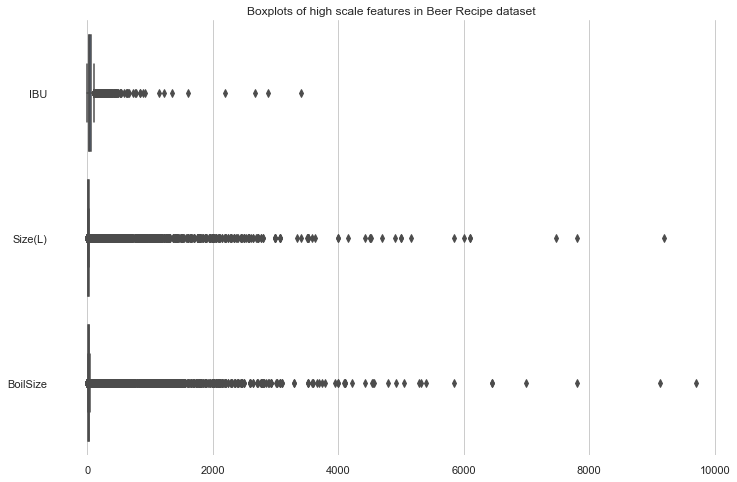

In [18]:
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(data=beer_recipe.loc[:, high_scale_feats], orient='h')
ax.set(title='Boxplots of high scale features in Beer Recipe dataset')
sns.despine(left=True, bottom=True)

In [19]:
print('There are {} different styles of beer'.format(beer_recipe.StyleID.nunique()))

There are 176 different styles of beer


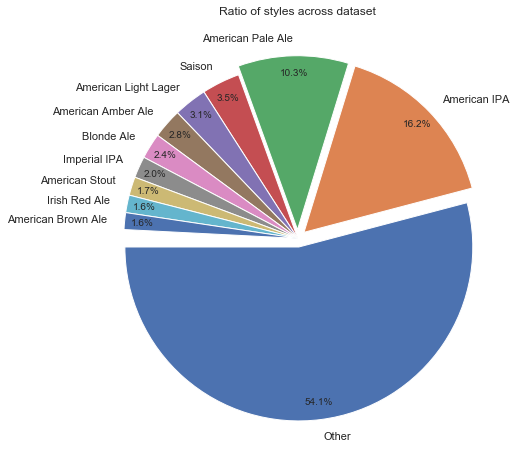

In [20]:
# Get top10 styles
top10_style = list(style_cnt_grp['Style'][:10].values)

# Group by current count information computed earlier and group every style not in top20 together
style_cnt_other = style_cnt_grp.loc[:, ['Style','Count']]
style_cnt_other.Style = style_cnt_grp.Style.apply(lambda x: x if x in top10_style else 'Other')
style_cnt_other = style_cnt_other.groupby('Style').sum()

# Get ratio of each style
style_cnt_other['Ratio'] = style_cnt_other.Count.apply(lambda x: x/float(len(beer_recipe)))
style_cnt_other = style_cnt_other.sort_values('Count', ascending=False)

f, ax = plt.subplots(figsize=(8, 8))
explode = (0.05, 0.05, 0.05, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(x=style_cnt_other['Ratio'], labels=list(style_cnt_other.index), startangle = 180, autopct='%1.1f%%', pctdistance= .9, explode=explode)
plt.title('Ratio of styles across dataset')
plt.show()

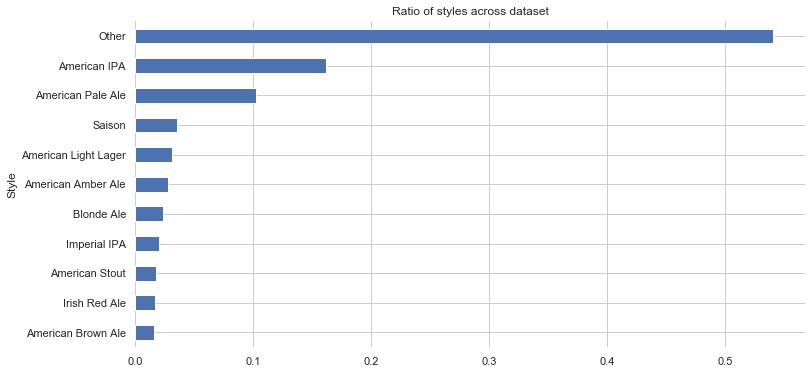

In [21]:
style_cnt_other['Ratio'].plot(kind='barh', figsize=(12,6),)
plt.title('Ratio of styles across dataset')
sns.despine(left=True, bottom=True)
plt.gca().invert_yaxis()

# Correlações

Conforme mencionado no trabalho anteriormente, uma receita dá-se pelos seguintes parâmetros, esses que por sua vez se correlacionam:

* Original Gravity (OG)
* Final Gravity (FG)
* Alcohol by Volume (ABV)
* Internation Bitterness Units (IBU)
* Color

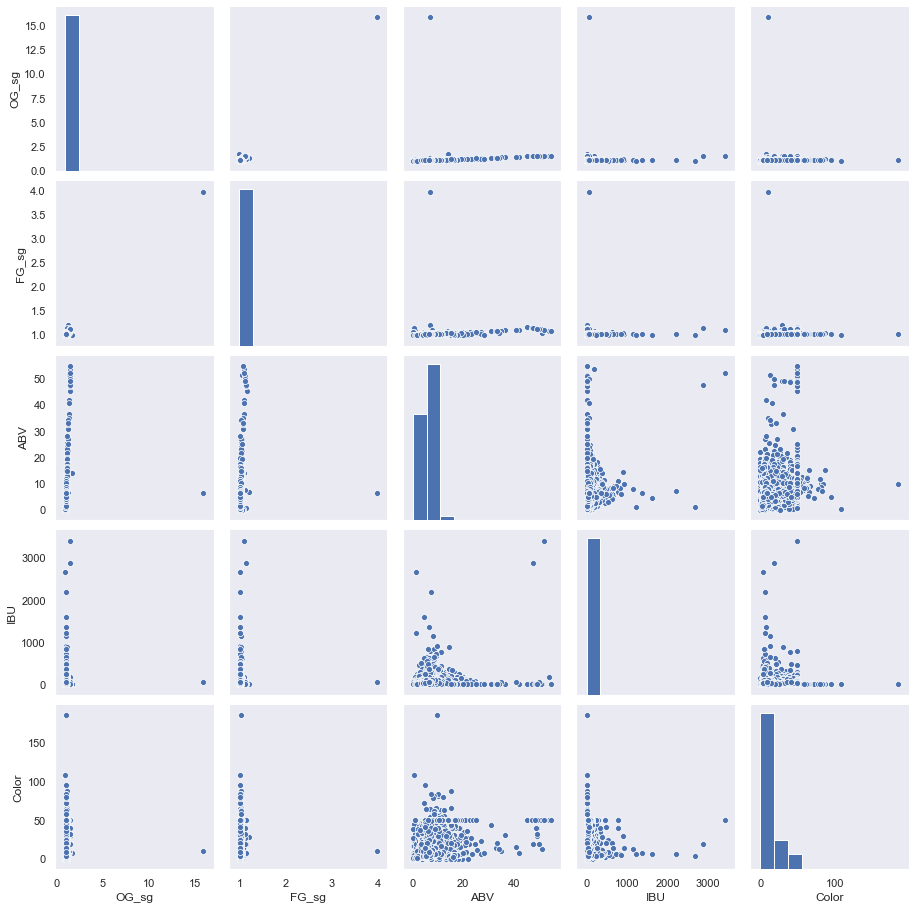

In [22]:
pairplot_df = beer_recipe.loc[:, ['Style','OG_sg','FG_sg','ABV','IBU','Color']]

# create the pairplot
sns.set(style="dark")
sns.pairplot(data=pairplot_df)
plt.show()

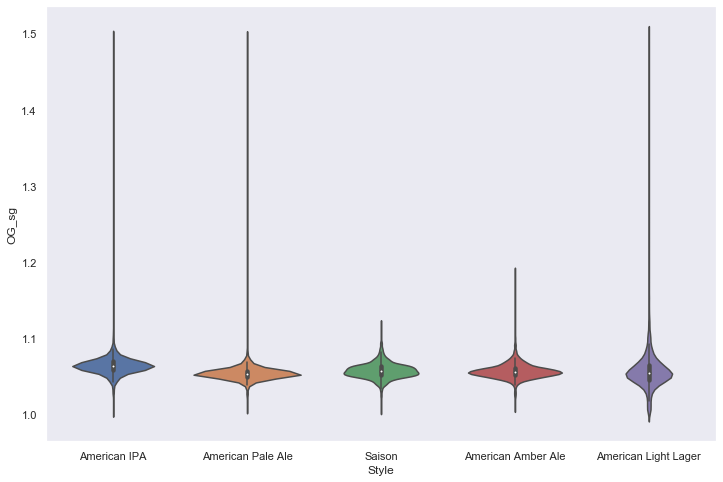

In [23]:
style_cnt_grp = style_cnt_grp.sort_values('Count', ascending=False)
top5_style = list(style_cnt_grp['Style'][:5].values)

top5_style_df = pairplot_df[pairplot_df['Style'].isin(top5_style)]

f, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(x='Style', y='OG_sg',data=top5_style_df)
plt.show()

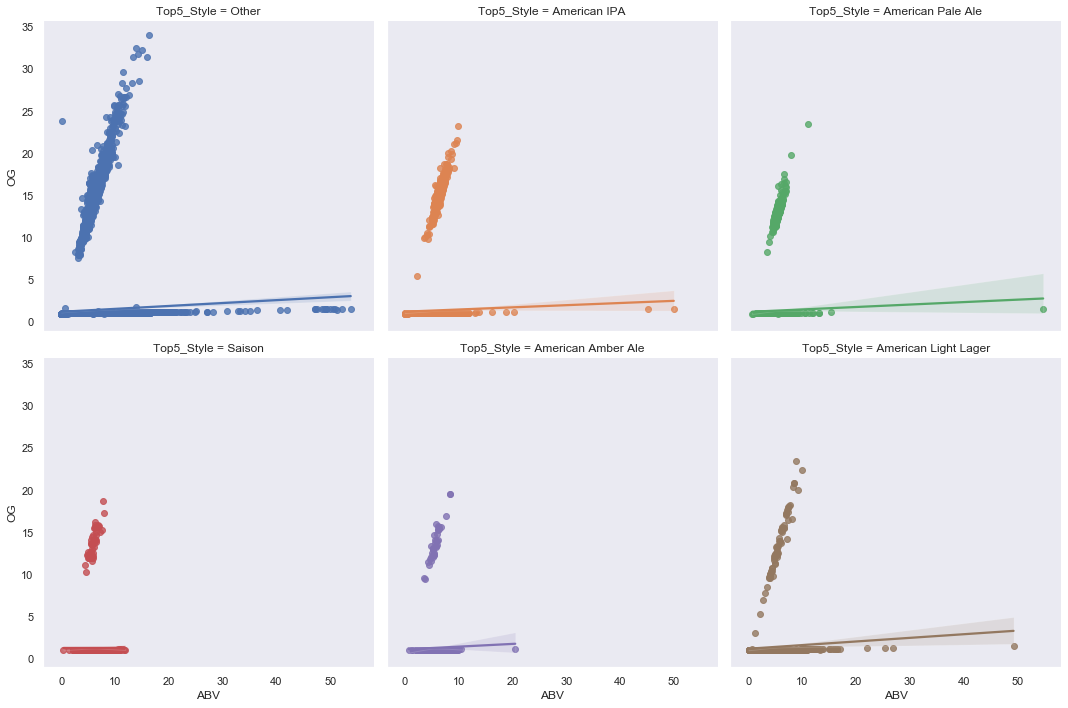

In [24]:
# Get Top5 styles
top5_style = list(style_cnt_grp['Style'][:5].values)
beer_recipe['Top5_Style'] = beer_recipe.Style.apply(lambda x: x if x in top5_style else 'Other')

# Create Reg plot
sns.lmplot(x='ABV', y='OG', hue='Top5_Style', col='Top5_Style', col_wrap=3, data=beer_recipe, n_boot=100)

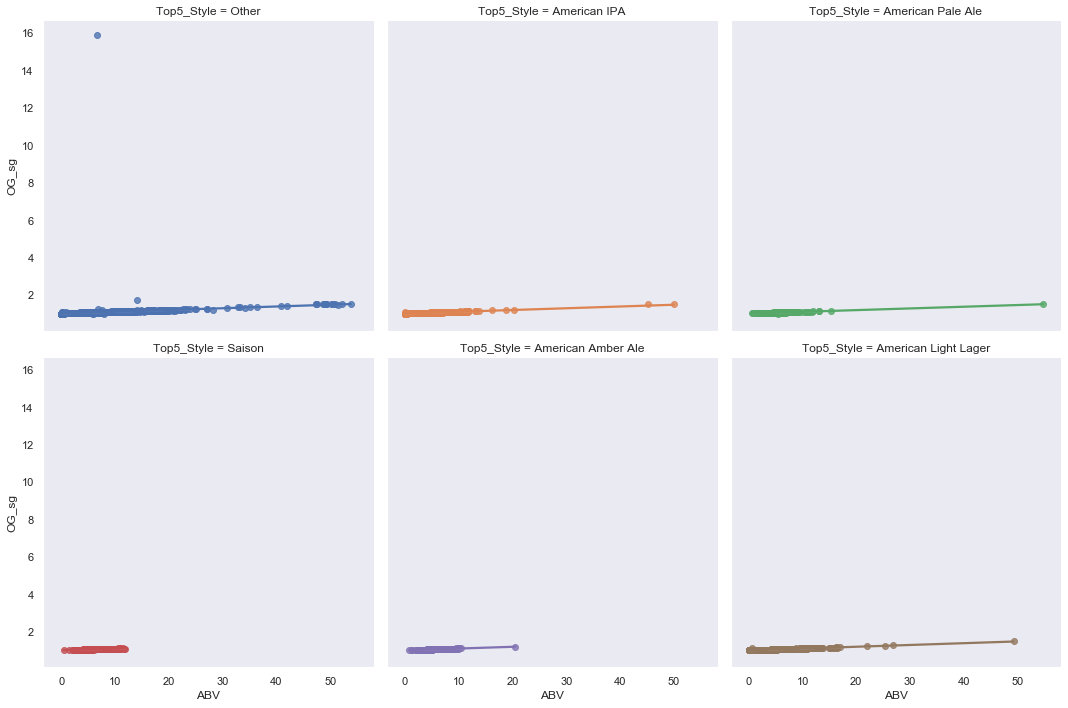

In [25]:
# Create Reg plot
sns.lmplot(x='ABV', y='OG_sg', hue='Top5_Style', col='Top5_Style', col_wrap=3, data=beer_recipe, n_boot=100)

# Classificador

Construindo um classificador com abordagens tradicionais

In [26]:
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.model_selection import train_test_split

# Get only the features to be used from original dataset
features_list= ['StyleID', #target
                'OG_sg','FG_sg','ABV','IBU','Color', #standardized fields
                'SugarScale', 'BrewMethod', #categorical features
                'Size(L)', 'BoilSize', 'BoilTime', 'BoilGravity_sg', 'Efficiency', 'MashThickness', 'PitchRate', 'PrimaryTemp' # other numerical features
                ]

clf_data = beer_recipe.loc[:, features_list]

# Label encoding
cat_feats_to_use = list(clf_data.select_dtypes(include=object).columns)
for feat in cat_feats_to_use:
    encoder = LabelEncoder()
    clf_data[feat] = encoder.fit_transform(clf_data[feat])

# Fill null values
num_feats_to_use = list(clf_data.select_dtypes(exclude=object).columns)
for feat in num_feats_to_use:
    imputer = Imputer(strategy='median')
    clf_data[feat] = imputer.fit_transform(clf_data[feat].values.reshape(-1,1))
    
# Seperate Targets from Features
X = clf_data.iloc[:, 1:]
y = clf_data.iloc[:, 0] #the target were the first column I included

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=35)

C:\ProgramData\Anaconda3\envs\env\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\envs\env\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\envs\env\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\envs\env\lib\site-packages\sklearn\utils\deprecation.py:66: Deprecati

In [27]:
#sanity check making sure everything is in number format and no null values
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73861 entries, 1 to 73861
Data columns (total 15 columns):
OG_sg             73861 non-null float64
FG_sg             73861 non-null float64
ABV               73861 non-null float64
IBU               73861 non-null float64
Color             73861 non-null float64
SugarScale        73861 non-null float64
BrewMethod        73861 non-null float64
Size(L)           73861 non-null float64
BoilSize          73861 non-null float64
BoilTime          73861 non-null float64
BoilGravity_sg    73861 non-null float64
Efficiency        73861 non-null float64
MashThickness     73861 non-null float64
PitchRate         73861 non-null float64
PrimaryTemp       73861 non-null float64
dtypes: float64(15)
memory usage: 11.5 MB


In [28]:
# imports
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
#sanity check again
sanity_df = pd.DataFrame(X_train, columns = X.columns)
sanity_df.describe().T

,count,mean,std,min,25%,50%,75%,max
OG_sg,59088.0,1.246781e-15,1.000008,-0.955853,-0.170667,-0.060741,0.096296,232.982515
FG_sg,59088.0,-1.128911e-14,1.000008,-1.723213,-0.223299,-0.073308,0.151679,221.988958
ABV,59088.0,4.608643e-17,1.000008,-3.284686,-0.569788,-0.184241,0.372661,25.529642
IBU,59088.0,-1.341313e-16,1.000008,-1.071731,-0.505069,-0.205129,0.298005,81.595006
Color,59088.0,-7.024949e-17,1.000008,-1.120069,-0.688844,-0.415874,0.279111,14.454289
SugarScale,59088.0,-5.739647e-16,1.000008,-6.166664,0.162162,0.162162,0.162162,0.162162
BrewMethod,59088.0,5.256123e-17,1.000008,-0.596869,-0.596869,-0.596869,0.389312,2.361672
Size(L),59088.0,1.050760e-15,1.000008,-0.236700,-0.138259,-0.127882,-0.112290,50.268734
BoilSize,59088.0,4.925788e-16,1.000008,-0.251126,-0.149391,-0.115410,-0.102270,49.533526
BoilTime,59088.0,-3.776746e-16,1.000008,-4.303005,-0.338050,-0.338050,-0.338050,11.556814


# Random Forest

In [30]:
#imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

clf = RandomForestClassifier()
#clf = LogisticRegression()
#clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\envs\env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('Accuracy: {}'.format(score))

Accuracy: 0.3327692411832397


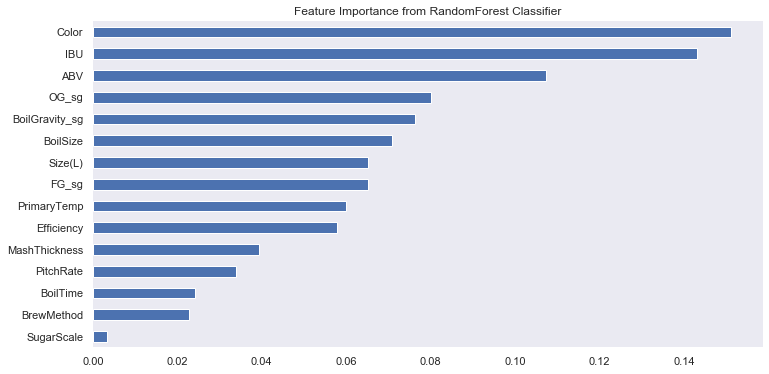

In [32]:
feats_imp = pd.DataFrame(clf.feature_importances_, index=X.columns, columns=['FeatureImportance'])
feats_imp = feats_imp.sort_values('FeatureImportance', ascending=False)

feats_imp.plot(kind='barh', figsize=(12,6), legend=False)
plt.title('Feature Importance from RandomForest Classifier')
sns.despine(left=True, bottom=True)
plt.gca().invert_yaxis()

# Logistic Regression

In [33]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\envs\env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\env\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('Accuracy: {}'.format(score))

Accuracy: 0.2265619711636093


# XGBoost

In [35]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [36]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('Accuracy: {}'.format(score))

Accuracy: 0.2702903946388682


## Classificando com Redes Neurais

* Abordagem alternativa para predizer receitas através de redes neurais

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [38]:
rec = pd.read_csv('D:/beer-recipes/recipeData.csv', encoding='latin1')

In [39]:
#drop columns that won't be used in prediction, non-recipe specific columns
rec.drop(columns=['MashThickness', 'PitchRate', 'PrimaryTemp', 'PrimingMethod', 'PrimingAmount', 'BoilGravity'], inplace = True)

In [40]:
#drop rows that do not have a style, this is our y(what we will predict)
rec.drop(rec[rec['Style'].isnull()].index, inplace =  True)

In [41]:
rec['IPA'] = rec['Style'].apply(lambda x: 1 if x.find('IPA') > -1 else 0)
rec['Porter'] = rec['Style'].apply(lambda x: 1 if x.find('Porter') > -1 else 0)
rec['Stout'] = rec['Style'].apply(lambda x: 1 if x.find('Stout') > -1 else 0)
rec['Ale'] = rec['Style'].apply(lambda x: 1 if x.find('Ale') > -1 else 0)
rec['Lager'] = rec['Style'].apply(lambda x: 1 if x.find('Lager') > -1 else (1 if x.find('Pils') > -1 else 0))
rec['Witbier'] = rec['Style'].apply(lambda x: 1 if x.find('Witbier') > -1 else 0)
rec['Saison'] = rec['Style'].apply(lambda x: 1 if x.find('Saison') > -1 else 0)

In [42]:
#defined styles present in dataset
rec[['IPA', 'Porter', 'Stout', 'Ale', 'Lager', 'Witbier', 'Saison']].sum().sum()

53592

In [43]:
#drop styles that don't fit into pre-defined categories
rec.drop(rec[(rec['IPA'] != 1) & (rec['Porter'] != 1) & (rec['Stout'] != 1) & (rec['Ale'] != 1) & (rec['Lager'] != 1) \
                      & (rec['Witbier'] != 1) & (rec['Saison'] != 1)].index, inplace = True)

In [44]:
#reset the index 
rec.reset_index(drop = True, inplace = True)

In [45]:
#setting column of ids for newly declared styles, reverse one-hot-encoded
rec['New_StyleID'] = 0

for i in range(rec.shape[0]):
    if rec.loc[i, 'IPA'] == 1:
        rec.loc[i, 'New_StyleID'] = 'IPA'
    elif rec.loc[i, 'Porter'] == 1:
        rec.loc[i, 'New_StyleID'] = 'Porter'
    elif rec.loc[i, 'Stout'] == 1:
        rec.loc[i, 'New_StyleID'] = 'Stout'
    elif rec.loc[i, 'Ale'] == 1:
        rec.loc[i, 'New_StyleID'] = 'Ale'
    elif rec.loc[i, 'Lager'] == 1:
        rec.loc[i, 'New_StyleID'] = 'Lager'
    elif rec.loc[i, 'Witbier'] == 1:
        rec.loc[i, 'New_StyleID'] = 'Witbier'
    elif rec.loc[i, 'Saison'] == 1:
        rec.loc[i, 'New_StyleID'] = 'Saison'

In [46]:
rec.head()

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,...,BrewMethod,UserId,IPA,Porter,Stout,Ale,Lager,Witbier,Saison,New_StyleID
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,...,All Grain,116.0,0,0,0,1,0,0,0,Ale
1,3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,...,extract,NaN,1,0,0,0,0,0,0,IPA
2,4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,...,All Grain,NaN,1,0,0,0,0,0,0,IPA
3,5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,...,All Grain,18325.0,0,0,0,1,0,0,0,Ale
4,6,Sierra Nevada Pale Ale Clone,/homebrew/recipe/view/28546/sierra-nevada-pale...,American Pale Ale,10,24.61,1.055,1.013,5.58,40.12,...,All Grain,5889.0,0,0,0,1,0,0,0,Ale


In [47]:
#dataframe showing totals of styles
style_agg = pd.DataFrame(rec[['IPA', 'Porter', 'Stout', 'Ale', 'Lager', 'Witbier', 'Saison']].sum(), columns = ['Style Count']).reset_index().rename(columns = {'index':'Style'}).sort_values(by = 'Style Count', ascending = False)
style_agg['percent'] = style_agg['Style Count'].apply(lambda x: x/style_agg['Style Count'].sum()*100)
style_agg

,Style,Style Count,percent
3,Ale,18859,35.189954
0,IPA,17064,31.840573
2,Stout,5954,11.109867
4,Lager,5326,9.938050
1,Porter,2700,5.038065
6,Saison,2617,4.883192
5,Witbier,1072,2.000299


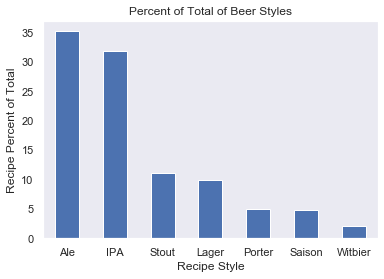

In [48]:
#plotting counts of styles
style_agg.plot(x = 'Style', y = 'percent', kind = 'bar', legend = False)
plt.title('Percent of Total of Beer Styles')
plt.xlabel('Recipe Style')
plt.ylabel('Recipe Percent of Total')
plt.xticks(rotation = 0);

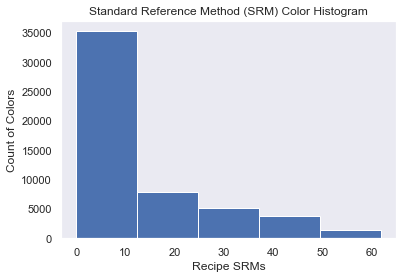

In [49]:
#histogram of color
rec.hist(column = 'Color', grid = False, bins = 15)
plt.xlim(-3, 65)
plt.title('Standard Reference Method (SRM) Color Histogram')
plt.xlabel('Recipe SRMs')
plt.ylabel('Count of Colors');

In [50]:
#declare X and y
X = rec[['OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilTime', 'Efficiency']]
y = rec[['IPA', 'Porter', 'Stout', 'Ale', 'Lager', 'Witbier', 'Saison']]

In [51]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#set as numpy array
y_train = y_train.as_matrix()
y_test = y_test.as_matrix()

C:\ProgramData\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\ProgramData\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [52]:
#standardizing data to normalize with a mean of 0 and a stdDev of 1
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [53]:
model = Sequential()

In [54]:
#network topology
input_units = X_train.shape[1]
hidden_units = 4

#input layer
model.add(Dense(hidden_units, 
                input_dim = input_units, 
                activation = 'relu',
                kernel_regularizer=regularizers.l2(0.0001)))
#hidden layer
model.add(Dense(50, activation = 'relu',))
#hidden layer
model.add(Dense(50, activation = 'relu',))



#output layer
model.add(Dense(7, activation = 'softmax'))

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 50)                250       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 357       
Total params: 3,189
Trainable params: 3,189
Non-trainable params: 0
_________________________________________________________________


In [56]:
#compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

In [57]:
#train the model
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   epochs = 30, 
                   batch_size = None, 
                   verbose = 1)

Train on 37514 samples, validate on 16078 samples
Epoch 1/30
37514/37514 [==============================] - 5s 141us/sample - loss: 1.1873 - accuracy: 0.5832 - val_loss: 1.0253 - val_accuracy: 0.6332
Epoch 2/30
37514/37514 [==============================] - 4s 105us/sample - loss: 0.9977 - accuracy: 0.6343 - val_loss: 0.9734 - val_accuracy: 0.6373
Epoch 3/30
37514/37514 [==============================] - 4s 104us/sample - loss: 0.9633 - accuracy: 0.6405 - val_loss: 0.9604 - val_accuracy: 0.6381
Epoch 4/30
37514/37514 [==============================] - 4s 103us/sample - loss: 0.9462 - accuracy: 0.6419 - val_loss: 0.9445 - val_accuracy: 0.6404
Epoch 5/30
37514/37514 [==============================] - 4s 103us/sample - loss: 0.9353 - accuracy: 0.6441 - val_loss: 0.9298 - val_accuracy: 0.6487
Epoch 6/30
37514/37514 [==============================] - 4s 102us/sample - loss: 0.9268 - accuracy: 0.6474 - val_loss: 0.9281 - val_accuracy: 0.6505
Epoch 7/30
37514/37514 [==========================

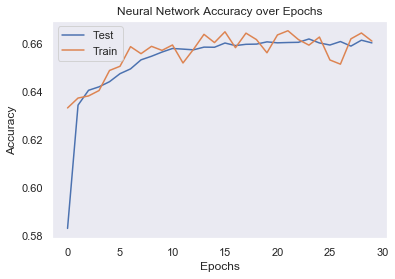

In [58]:
#plotting accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Neural Network Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Test', 'Train']);

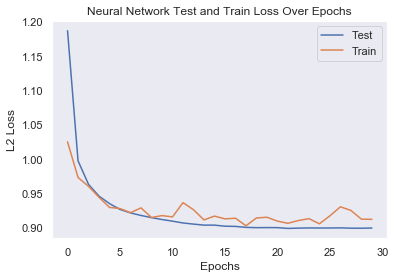

In [59]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(train_loss, label = 'Train loss')
plt.plot(test_loss, label = 'Test loss')
plt.legend();
plt.title('Neural Network Test and Train Loss Over Epochs')
plt.ylabel('L2 Loss')
plt.xlabel('Epochs')
plt.legend(['Test', 'Train']);